# Funciones extra

In [1]:
# Plot polynomials

def plotPoly(polys, name, L, R):
    x = var('x')
    a = plot([],figsize=(8, 8),title=name)
    classic_colors = ['crimson', 'blue', 'green', 'orange', 'purple', 'brown', 'red', 'yellow']
    n = len(polys)
    assert(n > 0)
    assert(len(L) == n and len(R) == n)
    for i in range(n):
        a += plot(polys[i], x, L[i], R[i], color=colors.keys()[i])
    show(a)

In [2]:
# Parse polynomial with coefficients

def parsePoly(poly):
    var('x')
    ans = 0
    mono = 1;
    for i in range(len(poly.list())):
        ans += poly.list()[i] * mono
        mono *= x
    return ans

In [3]:
# Plot polynomials with interpolation method "interpolation"

def plotPolylines(groups, name, interpolation):
    polynomials = []
    L = []
    R = []
    for points in groups:
        p = parsePoly(interpolation(points))
        polynomials.append(p)
        minimum = points[0][0]
        maximum = points[0][0]
        for i in range(1, len(points)):
            if points[i][0] < minimum: minimum = points[i][0]
            if points[i][0] > maximum: maximum = points[i][0]
        L.append(minimum)
        R.append(maximum)
    plotPoly(polynomials, name, L, R)

In [4]:
from sage.misc.lazy_format import LazyFormat

def printPolynomials(polys):
    for p in polys:
        print(p[0])
        print(LazyFormat("L = %d") % p[1])
        print(LazyFormat("R = %d") % p[2])

In [5]:
def plotSpline(polys, name):
    polynomials = []
    L = []
    R = []
    for p in polys:
        polynomials.append(p[0])
        L.append(p[1])
        R.append(p[2])
    plotPoly(polynomials, name, L, R)

# Algoritmos para Spline Cubica con Curvatura en los Extremos

In [6]:
def Gaussian(a, b):
    n = len(a)
    assert(n > 1)
    m = len(a[0])
    assert(m > 1)
    assert(len(b) == n)
    EPS = 1e-15
    ans = [None for _ in range(m)]
    where = [-1 for _ in range(m)]
    row = 0
    col = 0
    while(row < n and col < m):
        sel = row
        for i in range(row, n):
            if abs(a[i][col]) > abs(a[sel][col]):
                sel = i
        if abs(a[sel][col]) < EPS:
            continue
        for i in range(col, m):
            a[sel][i], a[row][i] = a[row][i], a[sel][i]
        b[sel], b[row] = b[row], b[sel]
        where[col] = row
        for i in range(n):
            if i == row: continue
            c = a[i][col] / a[row][col]
            for j in range(col, m):
                a[i][j] -= a[row][j] * c
            b[i] -= b[row] * c
        row += 1
        col += 1
    for i in range(m):
        if where[i] == -1: continue
        ans[i] = b[where[i]] / a[where[i]][i]
    for i in range(n):
        s = 0
        for j in range(m):
            s += a[i][j] * ans[j]
        if abs(s - b[i]) > EPS:
            for k in range(m):
                ans[k] = None
            return ans
    return ans

In [12]:
def CubicSplineCurvatura(points, Ds0, Dsn):
    n = len(points) - 1
    assert(n >= 2)
    h = [ points[i+1][0] - points[i][0] for i in range(n)]
    beta = [ (points[i+1][1] - points[i][1]) / h[i] for i in range(n) ]
    v = [ (None if i == 0 else 6 * (beta[i] - beta[i - 1])) for i in range(n)]
    a = [ [0 for _ in range(n - 1)] for _ in range(n - 1) ]
    b = [None for _ in range(n - 1)]
    a[0][0] = 2 * h[0] + 2 * h[1]
    a[0][1] = h[1]
    for i in range(1, n - 2):
        a[i][i] = 2 * (h[i] + h[i+1])
        a[i][i-1] = h[i]
        a[i][i+1] = h[i+1]
    a[n-2][n-3] = h[n-2] 
    a[n-2][n-2] = 2 * h[n-2] + 2 * h[n-1]
    b[0] = v[1] - h[0] * Ds0
    for i in range(1, n - 2):
        b[i] = v[i + 1]
    b[n-2] = v[n-1] - h[n-1] * Dsn
    lamb = Gaussian(a, b) # Solve Linear System Ax = b
    lambdas = [None for _ in range(n + 1)]
    lambdas[0] = Ds0
    lambdas[n] = Dsn
    for i in range(1, n):
        lambdas[i] = lamb[i-1]
    A = [points[i][1] for i in range(n)]
    B = [ (beta[i] - h[i] * (2 * lambdas[i] + lambdas[i+1]) / 6) for i in range(n)]
    C = [lambdas[i] / 2 for i in range(n)]
    D = [(lambdas[i+1] - lambdas[i]) / 6 / h[i] for i in range(n)]
    polynomials = []
    var('x')
    for i in range(n):
        cur = A[i] + B[i] * (x - points[i][0]) + C[i] * (x - points[i][0]) ** 2 + D[i] * (x - points[i][0]) ** 3
        polynomials.append([cur, points[i][0], points[i+1][0]])
    return polynomials # Returns polynomials with left and right limits for X

# Ejemplo

In [13]:
points = [(-3, 2), (-2, 0), (1, 3), (4, 1)]

P = CubicSplineCurvatura(points, -1, 2) # S''(-3) = -1 y S''(4) = 2

printPolynomials(P)

121/174*(x + 3)^3 - 1/2*(x + 3)^2 - 191/87*x - 133/29
L = -3
R = -2
-461/1566*(x + 2)^3 + 46/29*(x + 2)^2 - 193/174*x - 193/87
L = -2
R = 1
359/1566*(x - 1)^3 - 185/174*(x - 1)^2 + 40/87*x + 221/87
L = 1
R = 4


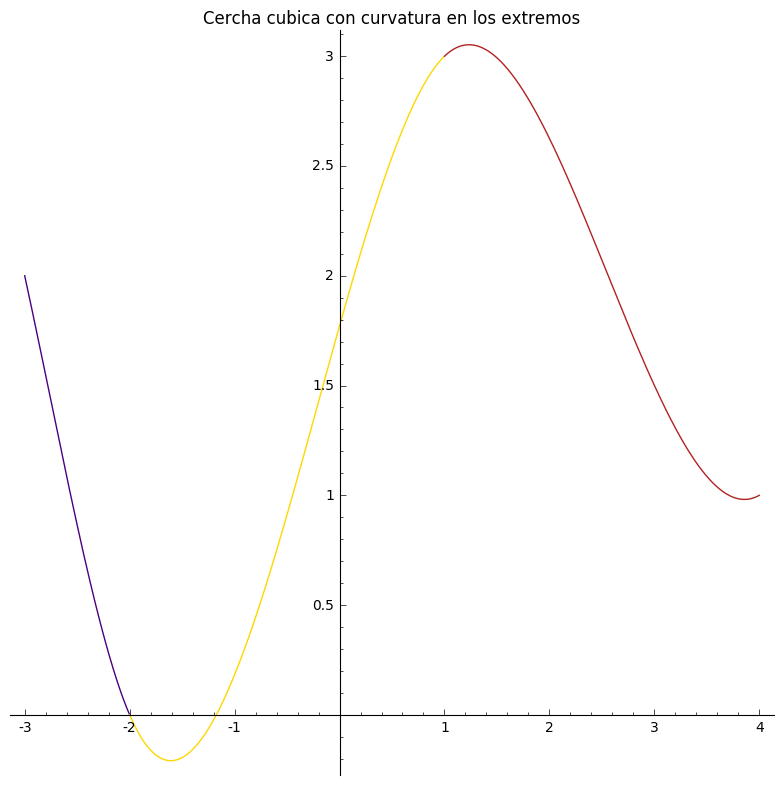

In [14]:
points = [(-3, 2), (-2, 0), (1, 3), (4, 1)]

P = CubicSplineCurvatura(points, -1, 2) # S''(-3) = -1 y S''(4) = 2

plotSpline(P, "Cercha cubica con curvatura en los extremos")